In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

In [2]:
import time

## Parameters

In [3]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 24,
    "epochs": 25,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [4]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [5]:
X_train = torch.load("../data/processed/aewi/train/train.pt")
X_val = torch.load("../data/processed/aewi/val/val.pt")

In [6]:
X_train.shape, X_val.shape

(torch.Size([28853, 1, 65536]), torch.Size([7351, 1, 65536]))

## Data Generators

In [7]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, mode="ae")
lsg_val = LibriSpeechGenerator(config, X_val, mode="ae")

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [8]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1),
                mode="linear")
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [9]:
model = SEWUNet(config)

In [10]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [11]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [12]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

In [13]:
# Copy model to device
model = model.to(device)

In [14]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1139372

In [15]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [16]:
# Train the model over epochs
steps = len(ls_generator)
start_time = time.time()

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)
    
elapsed_time = time.time() - start_time
history['elapsed_time'] = elapsed_time

Epoch [01/25], Step [100/1203], Loss: 0.0470360666513443, SNR: -4.634612560272217
Epoch [01/25], Step [200/1203], Loss: 0.028078293427824974, SNR: 0.6813809871673584
Epoch [01/25], Step [300/1203], Loss: 0.019930152222514153, SNR: 2.4386346340179443
Epoch [01/25], Step [400/1203], Loss: 0.016759850084781647, SNR: 4.690403938293457
Epoch [01/25], Step [500/1203], Loss: 0.014010514132678509, SNR: 6.495738983154297
Epoch [01/25], Step [600/1203], Loss: 0.011375775560736656, SNR: 6.919516563415527
Epoch [01/25], Step [700/1203], Loss: 0.01336431410163641, SNR: 7.380809783935547
Epoch [01/25], Step [800/1203], Loss: 0.01245047152042389, SNR: 7.048122406005859
Epoch [01/25], Step [900/1203], Loss: 0.009593264199793339, SNR: 8.642264366149902
Epoch [01/25], Step [1000/1203], Loss: 0.007468234281986952, SNR: 10.572569847106934
Epoch [01/25], Step [1100/1203], Loss: 0.008911725133657455, SNR: 9.686006546020508
Epoch [01/25], Step [1200/1203], Loss: 0.007566725369542837, SNR: 10.315718650817871


Epoch [08/25], Step [200/1203], Loss: 0.0013402756303548813, SNR: 23.30463218688965
Epoch [08/25], Step [300/1203], Loss: 0.0016621224349364638, SNR: 23.871129989624023
Epoch [08/25], Step [400/1203], Loss: 0.001297819777391851, SNR: 25.583372116088867
Epoch [08/25], Step [500/1203], Loss: 0.0011267568916082382, SNR: 24.883846282958984
Epoch [08/25], Step [600/1203], Loss: 0.001372415921650827, SNR: 26.313488006591797
Epoch [08/25], Step [700/1203], Loss: 0.0009867872577160597, SNR: 26.362735748291016
Epoch [08/25], Step [800/1203], Loss: 0.0018173041753470898, SNR: 22.94417953491211
Epoch [08/25], Step [900/1203], Loss: 0.0008854520274326205, SNR: 25.579723358154297
Epoch [08/25], Step [1000/1203], Loss: 0.0013934774324297905, SNR: 23.72597885131836
Epoch [08/25], Step [1100/1203], Loss: 0.0015089062508195639, SNR: 23.75481414794922
Epoch [08/25], Step [1200/1203], Loss: 0.0011654150439426303, SNR: 27.43630027770996
.:. Training metrics = Loss: 0.0013197085668160639, SNR: 24.741307091

Epoch [15/25], Step [300/1203], Loss: 0.0010008171666413546, SNR: 28.73556137084961
Epoch [15/25], Step [400/1203], Loss: 0.0008902368135750294, SNR: 26.582809448242188
Epoch [15/25], Step [500/1203], Loss: 0.0008332752622663975, SNR: 28.309097290039062
Epoch [15/25], Step [600/1203], Loss: 0.0006791872438043356, SNR: 26.962688446044922
Epoch [15/25], Step [700/1203], Loss: 0.0007951578591018915, SNR: 27.9884090423584
Epoch [15/25], Step [800/1203], Loss: 0.0007329705986194313, SNR: 25.02681541442871
Epoch [15/25], Step [900/1203], Loss: 0.0006942871259525418, SNR: 30.787006378173828
Epoch [15/25], Step [1000/1203], Loss: 0.0010609871242195368, SNR: 24.8846492767334
Epoch [15/25], Step [1100/1203], Loss: 0.0008617431740276515, SNR: 29.7806396484375
Epoch [15/25], Step [1200/1203], Loss: 0.001134936697781086, SNR: 26.731733322143555
.:. Training metrics = Loss: 0.0009044113316477594, SNR: 27.810393481611055
.:. Validation metrics = Loss: 0.0008876174489747459, SNR: 28.207541177360692
Ep

Epoch [22/25], Step [400/1203], Loss: 0.0004281392029952258, SNR: 29.600772857666016
Epoch [22/25], Step [500/1203], Loss: 0.0007692743092775345, SNR: 27.54511070251465
Epoch [22/25], Step [600/1203], Loss: 0.0008547880570404232, SNR: 30.853267669677734
Epoch [22/25], Step [700/1203], Loss: 0.00033692092983983457, SNR: 34.62928009033203
Epoch [22/25], Step [800/1203], Loss: 0.0004580840468406677, SNR: 29.910179138183594
Epoch [22/25], Step [900/1203], Loss: 0.0005038361996412277, SNR: 31.23567771911621
Epoch [22/25], Step [1000/1203], Loss: 0.0003487259382382035, SNR: 32.54907989501953
Epoch [22/25], Step [1100/1203], Loss: 0.00038332026451826096, SNR: 32.30652618408203
Epoch [22/25], Step [1200/1203], Loss: 0.0005044196732342243, SNR: 29.443082809448242
.:. Training metrics = Loss: 0.0005293053352253569, SNR: 30.086218932916672
.:. Validation metrics = Loss: 0.0004818695804612946, SNR: 30.26953254215021
Epoch [23/25], Step [100/1203], Loss: 0.0005247099325060844, SNR: 29.3822994232177

In [17]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

In [18]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_batch
}, config.checkpoint_path)

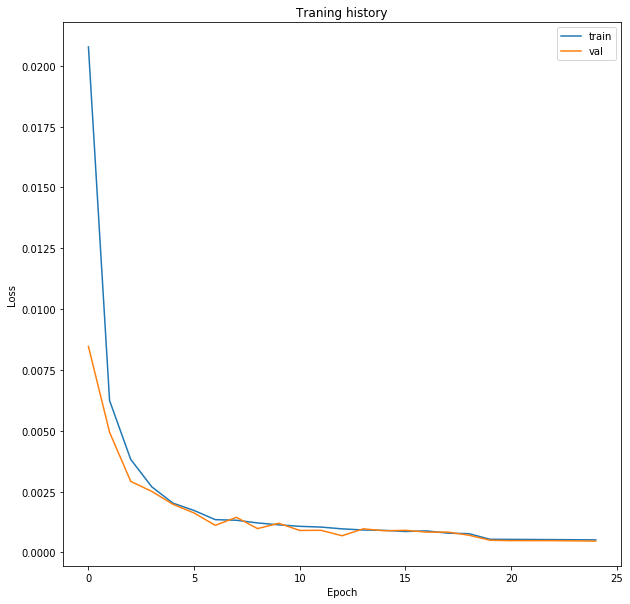

In [19]:
# Plot network history
plt.figure(figsize=(10,10))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

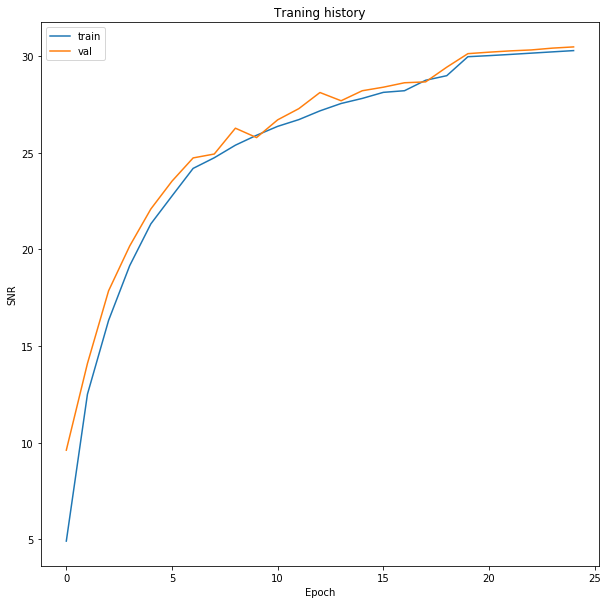

In [20]:
# Plot network history
plt.figure(figsize=(10,10))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [21]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

In [22]:
with torch.no_grad():
    for local_batch, local_labels in ls_val_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)